In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
class TrafficSignClassification:
    def __init__(self, train_folder, test_folder, img_size=(32, 32), max_images_per_class=100):
        self.train_folder = train_folder
        self.test_folder = test_folder
        self.img_size = img_size
        self.max_images_per_class = max_images_per_class
        self.data = []
        self.labels = []

    def load_data(self, folder):
        data = []
        labels = []

        for label in range(43):  # 43 classes (0 to 42)
            class_folder = os.path.join(folder, str(label))
            if not os.path.exists(class_folder):
                print(f"Folder {class_folder} does not exist!")
                continue

            files = os.listdir(class_folder)
            for idx, file in enumerate(files):
                if idx >= self.max_images_per_class:
                    break
                file_path = os.path.join(class_folder, file)
                image = cv2.imread(file_path)
                if image is None:
                    continue
                image = cv2.resize(image, self.img_size)
                data.append(image)
                labels.append(label)

        data = np.array(data, dtype=np.float32) / 255.0
        labels = np.array(labels)
        return data, labels

    def prepare_data(self):
        print("Loading training data...")
        self.data, self.labels = self.load_data(self.train_folder)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.labels, test_size=0.2, random_state=42
        )
        print(f"Training data: {self.X_train.shape}")
        print(f"Test data: {self.X_test.shape}")

    def grid_search(self, model, param_grid):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
        X_train_flat = self.X_train.reshape(self.X_train.shape[0], -1)  # Flatten images
        X_test_flat = self.X_test.reshape(self.X_test.shape[0], -1)  # Also Flatten images

        grid_search.fit(X_train_flat, self.y_train)
        best_model = grid_search.best_estimator_

        print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
        
        predictions = best_model.predict(X_test_flat)
        print(f"Classification Report:\n{classification_report(self.y_test, predictions)}")
        print(f"Confusion Matrix:\n{confusion_matrix(self.y_test, predictions)}")

        return best_model

    def train_knn(self):
        param_grid = {
            'n_neighbors': [3, 5, 7, 9]
        }
        knn = KNeighborsClassifier()
        return self.grid_search(knn, param_grid)

    def train_svm(self):
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        }
        svm = SVC()
        return self.grid_search(svm, param_grid)

    def train_decision_tree(self):
        param_grid = {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        decision_tree = DecisionTreeClassifier()
        return self.grid_search(decision_tree, param_grid)

    def train_random_forest(self):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        random_forest = RandomForestClassifier()
        return self.grid_search(random_forest, param_grid)

    def train_softmax_regression(self):
        param_grid = {
            'C': [0.1, 1, 10],
            'max_iter': [100, 200, 300]
        }
        logistic = LogisticRegression(multi_class='multinomial', max_iter=1000)
        return self.grid_search(logistic, param_grid)


    def train_cnn(self):
        y_train_categorical = to_categorical(self.y_train, 43)
        y_test_categorical = to_categorical(self.y_test, 43)

        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(self.img_size[0], self.img_size[1], 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(43, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(self.X_train, y_train_categorical,
                            validation_data=(self.X_test, y_test_categorical),
                            epochs=10, batch_size=32, verbose=1)

        _, accuracy = model.evaluate(self.X_test, y_test_categorical, verbose=0)
        print(f"CNN Accuracy: {accuracy * 100:.2f}%")
        self.cnn_model = model

        # Save the model using Keras' built-in method
        keras.saving.save_model(model, 'my_model.keras')
        print("Model saved as cnn_model.h5")


    def load_model(self):
        # Load the model using Pickle
        with open('cnn_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        print("Model loaded from cnn_model.pkl")
        return loaded_model

    def visualize_samples(self):
        plt.figure(figsize=(12, 8))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(self.X_train[i])
            plt.title(f"Label: {self.y_train[i]}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

Loading training data...
Training data: (3440, 32, 32, 3)
Test data: (860, 32, 32, 3)


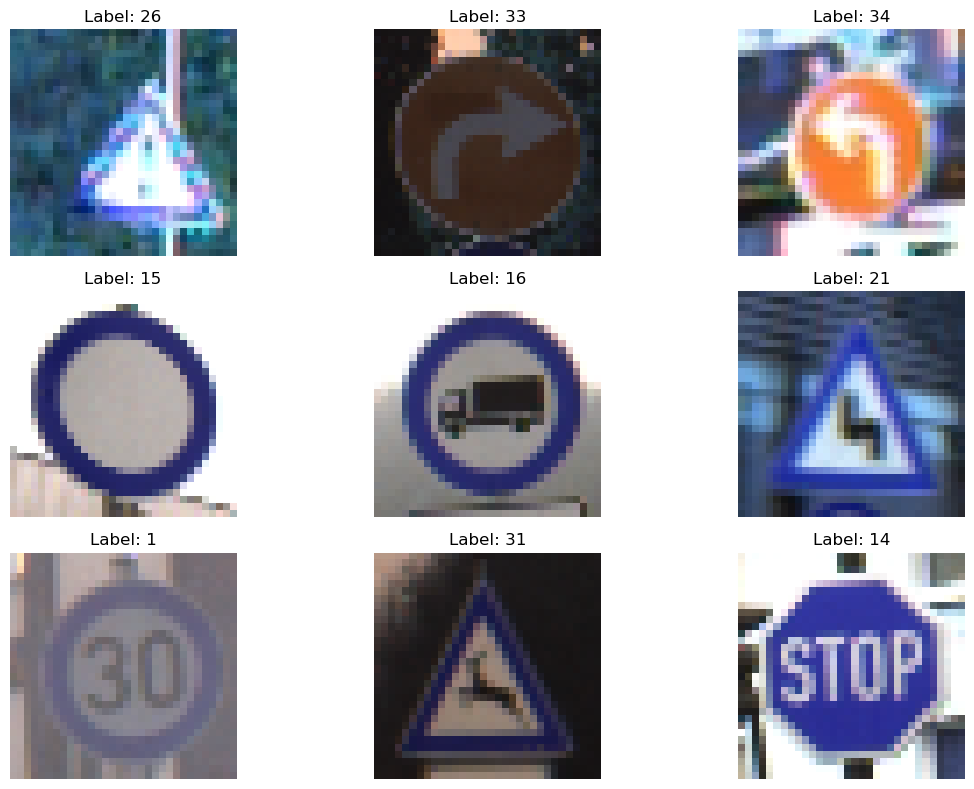


Training KNN...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.79      0.96      0.87        24
           2       0.82      0.92      0.87        25
           3       0.72      0.72      0.72        18
           4       0.84      1.00      0.91        21
           5       0.81      1.00      0.89        21
           6       0.95      1.00      0.97        18
           7       0.91      1.00      0.95        20
           8       0.92      1.00      0.96        22
           9       0.92      0.92      0.92        13
          10       1.00      1.00      1.00        25
          11       0.94      0.68      0.79        25
          12       0.92      0.88      0.90        26
          13       0.62      1.00      0.77        18
          14       1.00     

C:\Users\mr\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0538 - loss: 3.6462 - val_accuracy: 0.3605 - val_loss: 2.7631
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2877 - loss: 2.5765 - val_accuracy: 0.6860 - val_loss: 1.3200
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5552 - loss: 1.5912 - val_accuracy: 0.8477 - val_loss: 0.7948
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6953 - loss: 1.0582 - val_accuracy: 0.9058 - val_loss: 0.5156
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7812 - loss: 0.7976 - val_accuracy: 0.9453 - val_loss: 0.3093
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8300 - loss: 0.6153 - val_accuracy: 0.9581 - val_loss: 0.2338
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8517 - loss: 0.5298 - val_accuracy: 0.9605 - val_loss: 0.2035
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8628 - loss: 0.4536 - val_accuracy: 0.979

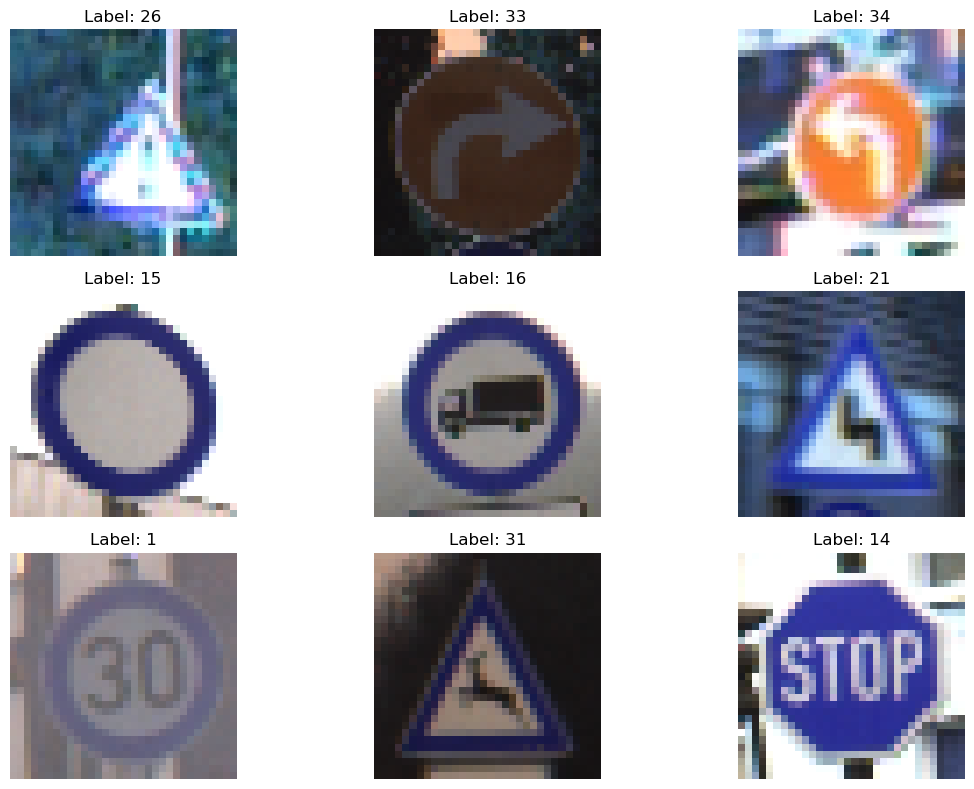


Training KNN...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.79      0.96      0.87        24
           2       0.82      0.92      0.87        25
           3       0.72      0.72      0.72        18
           4       0.84      1.00      0.91        21
           5       0.81      1.00      0.89        21
           6       0.95      1.00      0.97        18
           7       0.91      1.00      0.95        20
           8       0.92      1.00      0.96        22
           9       0.92      0.92      0.92        13
          10       1.00      1.00      1.00        25
          11       0.94      0.68      0.79        25
          12       0.92      0.88      0.90        26
          13       0.62      1.00      0.77        18
          14       1.00     

In [ ]:
csv_train = "train.csv"
csv_test = "test.csv"
test_folder = r"E:\DataScience BootCamp\Udemy\Projects\Computer Vision\Computetr Vision\Traffic Classification\Test"
train_folder = r"E:\DataScience BootCamp\Udemy\Projects\Computer Vision\Computetr Vision\Traffic Classification\Train"

classifier = TrafficSignClassification(train_folder, test_folder, img_size=(32, 32))

classifier.prepare_data()

classifier.visualize_samples()

print("\nTraining KNN...")
classifier.train_knn()

print("\nTraining CNN...")
cnn_model = classifier.train_cnn()

print("\nTraining SVM...")
classifier.train_svm()

print("\nTraining Decision Tree...")
classifier.train_decision_tree()

print("\nTraining Random Forest...")
classifier.train_random_forest()

print("\nTraining Softmax Regression...")
classifier.train_softmax_regression()

Loading training data...
Training data: (3440, 32, 32, 3)
Test data: (860, 32, 32, 3)


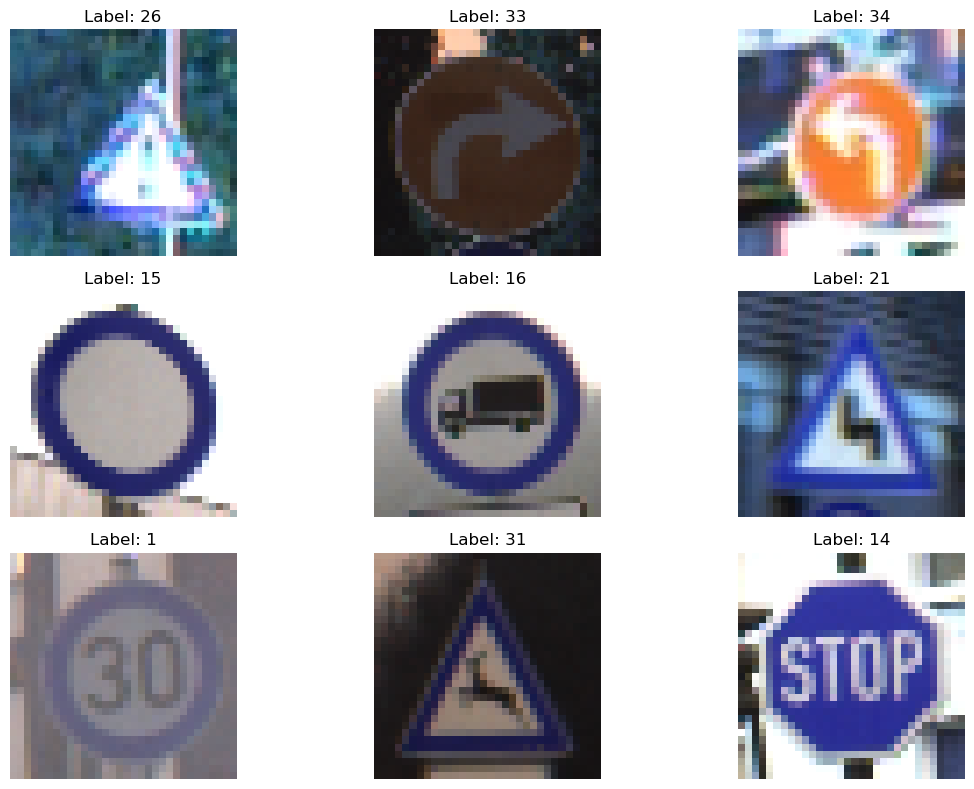

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.79      0.96      0.87        24
           2       0.82      0.92      0.87        25
           3       0.72      0.72      0.72        18
           4       0.84      1.00      0.91        21
           5       0.81      1.00      0.89        21
           6       0.95      1.00      0.97        18
           7       0.91      1.00      0.95        20
           8       0.92      1.00      0.96        22
           9       0.92      0.92      0.92        13
          10       1.00      1.00      1.00        25
          11       0.94      0.68      0.79        25
          12       0.92      0.88      0.90        26
          13       0.62      1.00      0.77        18
          14       1.00      0.96      0.98  

KNeighborsClassifier(n_neighbors=3)

In [46]:
classifier.train_knn()

In [47]:
knn_model = classifier.load_model()

KNN Model loaded from knn_model.pkl


In [48]:
import pickle

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)